In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from parameters import *
from functions import *

filenames = dict()
execfile('filenames.sh', filenames)

%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def read_words(filename):
    with file(filename) as f:
        return [line.split(',')[0] for line in f]
    
word_freq_experiment_words = read_words(filenames['word_freq_experiment_words'])
coocc_noise_experiment_words = read_words(filenames['coocc_noise_experiment_words'])

In [3]:
vectors_syn0 = load_word2vec_binary(filenames['vectors_binary'])
norms_syn0 = np.sqrt((vectors_syn0 ** 2).sum(axis=1))

vectors_syn1neg = load_word2vec_binary(filenames['vectors_binary'] + '.syn1neg')
norms_syn1neg = np.sqrt((vectors_syn1neg ** 2).sum(axis=1))

vocab = list(vectors_syn0.index)
print 'vocab size: ', len(vocab)


vocab size:  62019


# Calculate frequencies in the modified corpus

In [4]:
with file(filenames['corpus_modified']) as f:
    new_counts = count_words(f)
    total_words = sum(new_counts.values())

In [93]:
stats = pd.DataFrame({'occurrences': new_counts, 'L2_norm_syn0': norms_syn0, 'L2_norm_syn1neg': norms_syn1neg}).dropna()
stats['occurrences_band'] = np.floor(np.log2(stats.occurrences)).astype(int)
stats['log2_frequency'] = np.log2(stats.occurrences * 1. / total_words)
stats.L2_norm_syn0.name = 'L2 norm (syn0)'
stats.L2_norm_syn1neg.name = 'L2 norm (syn1neg)'

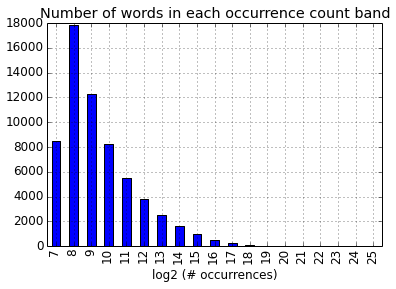

In [95]:
band_counts = stats.occurrences_band.dropna().value_counts().sort_index()
band_counts.index.name = 'log2 (# occurrences)'

_ = band_counts.plot(kind='bar', title='Number of words in each occurrence count band')
plt.savefig('occurrence-histogram.eps')

## The global relationship between L2 norm and frequency

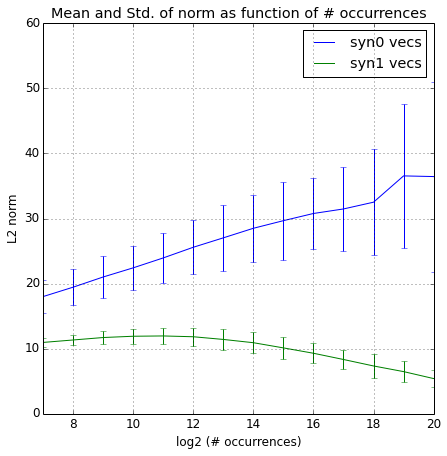

In [98]:
band_gb = stats.groupby('occurrences_band')

means = band_gb.L2_norm_syn0.mean()
errors = band_gb.L2_norm_syn0.std()
ax = means.plot(yerr=errors)

means = band_gb.L2_norm_syn1neg.mean()
errors = band_gb.L2_norm_syn1neg.std()
ax = means.plot(yerr=errors, figsize=(7,7))

_ = ax.set_title('Mean and Std. of norm as function of # occurrences')
_ = ax.set_xlim(7, 20)
_ = ax.set_ylim(0, 60)

_ = ax.set_xlabel('log2 (# occurrences)')
_ = ax.set_ylabel('L2 norm')

plt.legend(['syn0 vecs', 'syn1 vecs'])
plt.savefig('frequency-norm-graph.eps')

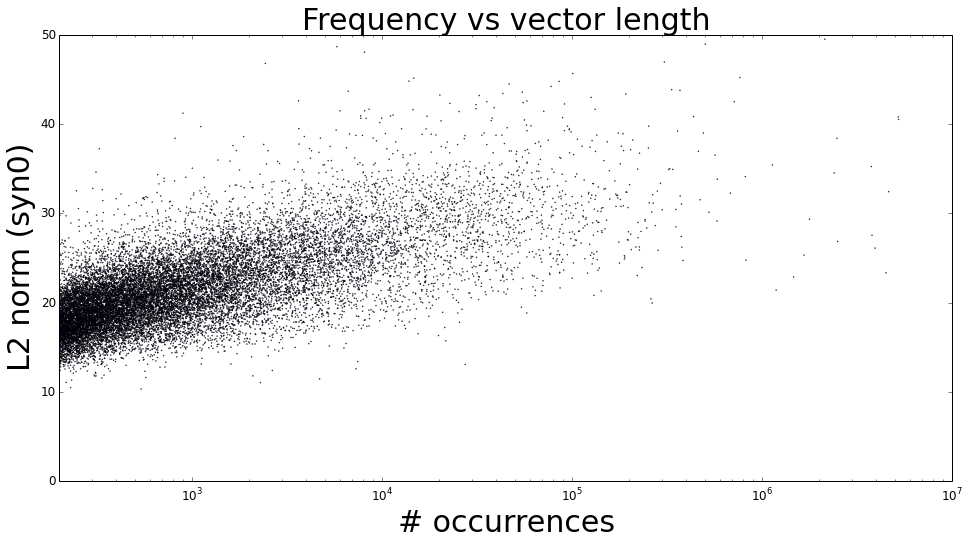

In [88]:
# scatter plot of syn0 norm vs frequency for a sample of ordinary (non-experiment-) words
fig = plt.figure(figsize=(16, 8))
non_experiment_words = [word for word in stats.index if word != word.upper()]
sample = stats.loc[random.sample(non_experiment_words, 20000)]
plt.scatter(sample.occurrences, sample.L2_norm_syn0, s=0.2)
plt.xscale('log')
plt.ylim(0, 50)
plt.xlim(200, 10 ** 7)
plt.title('Frequency vs vector length').set_fontsize(30)
plt.xlabel('# occurrences').set_fontsize(30)
plt.ylabel('L2 norm (syn0)').set_fontsize(30)
plt.savefig('frequency-norm-scatterplot.eps')

In [8]:
def set_num_plots(num_plots):
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

## Word Frequency Experiment

In [9]:
plot_words = word_freq_experiment_words + [meaningless_token, onehot_token]

def plot_word_freq_experiment_norm_vs_freq(norms_vs_freq):
    plt.figure(figsize=(7, 7))
    plt.title('Norm of word vector when word frequency is varied')
    plt.xlabel('log2 (# occurrences)')
    plt.ylabel(norms_vs_freq.name)
    set_num_plots(len(word_freq_experiment_words))

    def plot_for_word(word, **kwargs):
        idxs = [build_experiment_token(word, i) for i in range(1, max(word_freq_experiment_ratio, word_freq_experiment_power_max) + 1)]
        x = np.log2(stats.loc[idxs].occurrences)
        y = norms_vs_freq.loc[idxs]
        plt.plot(x, y, marker='o', **kwargs)

    for word in plot_words:
        plot_for_word(word)

    _ = plt.legend(plot_words, loc='upper right')
    plt.tight_layout()


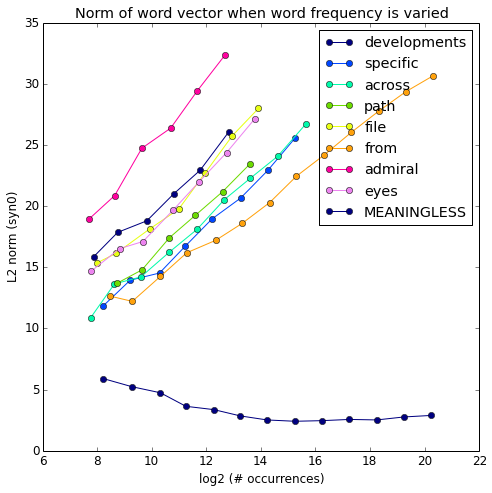

In [10]:
plot_word_freq_experiment_norm_vs_freq(stats.L2_norm_syn0)
plt.savefig('word-frequency-experiment-graph-syn0.eps')

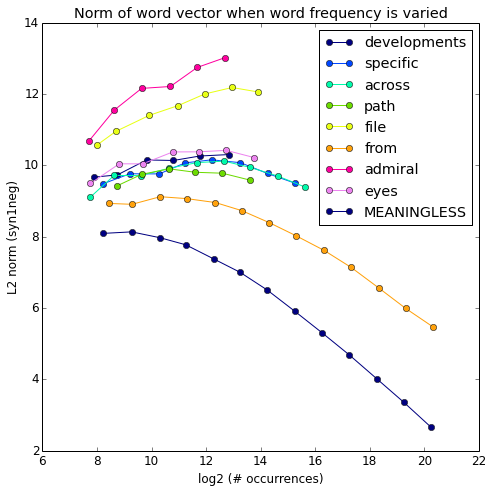

In [11]:
plot_word_freq_experiment_norm_vs_freq(stats.L2_norm_syn1neg)
plt.savefig('word-frequency-experiment-graph-syn1neg.eps')

In [33]:
def cosine_similarity_heatmap(test_vecs, **kwargs):
    test_vecs_normed = test_vecs.as_matrix() / np.sqrt((test_vecs ** 2).sum(axis=1))[:,np.newaxis]
    mat = test_vecs_normed.dot(test_vecs_normed.transpose())    
    plt.figure(**kwargs)
    plt.title('Dot product of normalised word vectors')
    plt.pcolor(mat, vmin=-1, vmax=1)
    plt.colorbar()
    _ = plt.yticks(np.arange(0.5, len(test_vecs.index), 1), test_vecs.index)
    _ = plt.xticks(np.arange(0.5, len(test_vecs.index), 1), test_vecs.index, rotation=90)

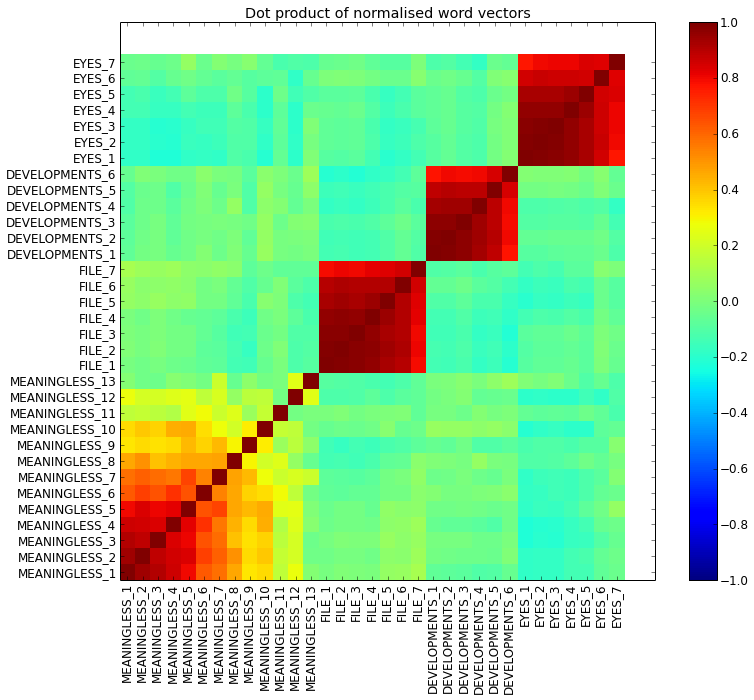

In [45]:
test_words = [meaningless_token, onehot_token] + random.sample(word_freq_experiment_words, 3)
idxs = [build_experiment_token(word, i) for word in test_words for i in range(1, max(word_freq_experiment_ratio, word_freq_experiment_power_max) + 1)]
test_vecs = vectors_syn0.loc[idxs].dropna()
cosine_similarity_heatmap(test_vecs, figsize=(12, 10))
plt.savefig('word-frequency-experiment-heatmap.eps')

## Co-occurrence noise experiment

In [16]:
def plot_coocc_noise_experiment_norm_vs_freq(norms_vs_freq):
    plt.figure(figsize=(7, 7))
    plt.title('Norm when noise added to cooccurrence distribution')
    plt.xlabel('Proportion of noise occurrences')
    plt.ylabel(norms_vs_freq.name)

    plt.xlim(0, 1)
    set_num_plots(len(coocc_noise_experiment_words))
    def plot_for_word(word, **kwargs):
        exponents = filter(lambda i: build_experiment_token(word, i) in stats.index, range(1, coocc_noise_experiment_power_max + 1))
        idxs = [build_experiment_token(word, i) for i in exponents]
        x = [1 - coocc_noise_experiment_ratio ** exponent for exponent in exponents]
        y = norms_vs_freq.loc[idxs]
        plt.plot(x, y, marker='o', **kwargs)

    for word in coocc_noise_experiment_words:
        plot_for_word(word)

    _ = plt.legend(coocc_noise_experiment_words, loc='upper right')
    plt.tight_layout()

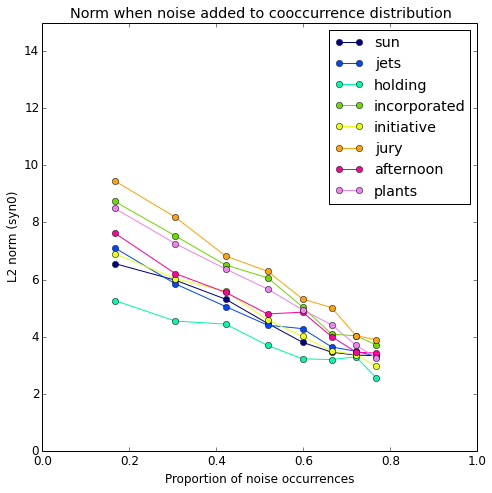

In [20]:
plot_coocc_noise_experiment_norm_vs_freq(stats.L2_norm_syn0)
plt.ylim(0, 15)
plt.savefig('cooccurrence-noise-graph-syn0.eps')

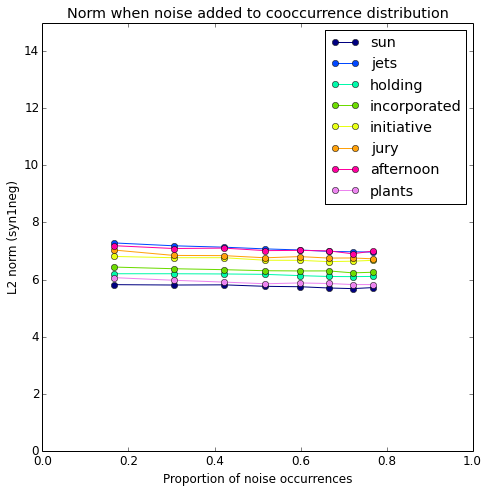

In [21]:
plot_coocc_noise_experiment_norm_vs_freq(stats.L2_norm_syn1neg)
plt.ylim((0,15))
plt.savefig('cooccurrence-noise-graph-syn1neg.eps')

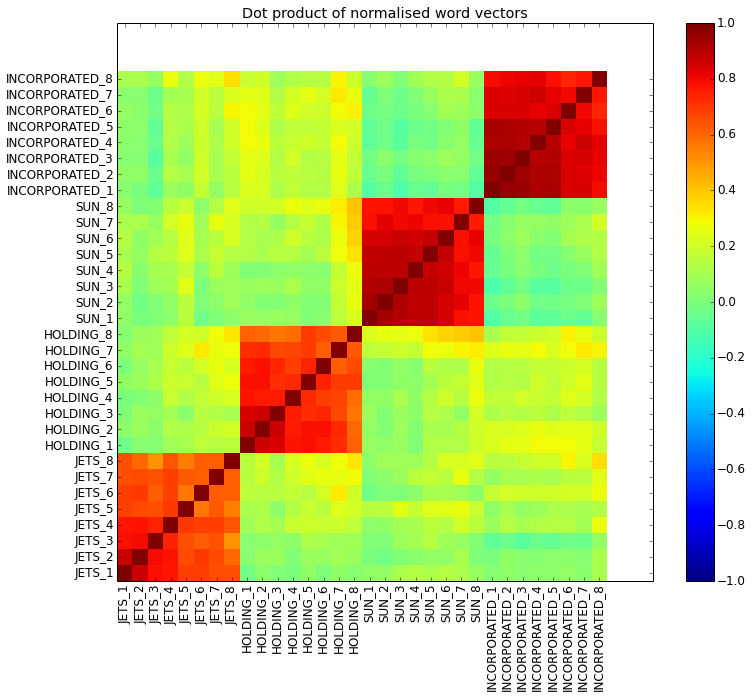

In [50]:
idxs = []
for word in random.sample(coocc_noise_experiment_words, 4):
    idxs += [build_experiment_token(word, i) for i in range(1, coocc_noise_experiment_power_max + 1)]

# to check for colinearity, we need to subtract the vector that they all converge to, viz. the meaningless vector.
meaningless_vec = vectors_syn0.loc[build_experiment_token(meaningless_token, 1)]
test_vecs = vectors_syn0.loc[idxs].dropna() - meaningless_vec
cosine_similarity_heatmap(test_vecs, figsize=(12, 10))
plt.savefig('cooccurrence-noise-heatmap.eps')